## Dependencies:

In [1]:
import json
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import OrderedDict

## Load data:

In [2]:
with open('../data/run.json') as f:
    data = json.load(f)
    
audit = []
for line in open('../data/audits.json', 'r'):
    audit.append(json.loads(line))

## Prototype number crunching:

In [3]:
uid_to_token = dict()
item_to_existing_uid = dict()
for audit_log in audit:
    if audit_log['type'] == 'PREPARE_JUDGEMENT':
        uid_to_token[audit_log['submission']['uid']] = audit_log['token']
        if audit_log['submission']['uid'] not in item_to_existing_uid:
            item_to_existing_uid[audit_log['submission']['item']['id'] + '-' + str(audit_log['submission']['start'])] = audit_log['submission']['uid']
        
token_to_judgeId = dict()
for audit_log in audit:
    if audit_log['type'] == 'JUDGEMENT':
        token_to_judgeId[audit_log['token']] = audit_log['user']
        
user_to_judge_name = dict()
for audit_log in audit:
    if audit_log['type'] == 'LOGIN':
        if 'judge' in audit_log['user']:
            user_to_judge_name[audit_log['session']] = audit_log['user']
            
uid_to_judge_name = dict()
for uid in uid_to_token.keys():
    if uid_to_token[uid] in token_to_judgeId:
        uid_to_judge_name[uid] = user_to_judge_name[token_to_judgeId[uid_to_token[uid]]]
        
        
item_to_judge = dict()
for audit_log in audit:
    if audit_log['type'] == 'SUBMISSION':
        if audit_log['submission']['uid'] in uid_to_judge_name:
            item = audit_log['submission']['item']['id'] + '-' + str(audit_log['submission']['start'])
            item_to_judge[item] = uid_to_judge_name[item_to_existing_uid[item]]


## Additional data loading:

In [4]:
v3c1_ids = dict()

with open('../data/v3c1_segments.csv', mode='r') as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        if row[0] not in v3c1_ids:
            v3c1_ids[row[0]] = dict()
        v3c1_ids[row[0]][row[2]] = row[1]

class Shot:
    def __init__(self, shotStart, shotEnd, segmentId):
        self.shotStart = int(shotStart)
        self.shotEnd = int(shotEnd)
        self.segmentId = int(segmentId)
        
    def isWithin(self, shotId):
        return shotId >= self.shotStart and shotId <= self.shotEnd
    
    def get_segmentId(self):
        return self.segmentId
        
v3c1_ids_shots = dict()
with open('../data/v3_c1_frame_segments.csv', mode='r') as infile:
    reader = csv.reader(infile)
    is_header = True
    for row in reader:
        if is_header:
            is_header = False
            continue
        if row[0] not in v3c1_ids_shots:
            v3c1_ids_shots[row[0]] = []
        v3c1_ids_shots[row[0]].append(Shot(row[3], row[5], row[1]))
        
judge_dict = dict()
node_dict = dict()
with open('../data/judgements.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
        judge_dict[row[4]] = row[3]
        node_dict[row[4]] = row[1]

## Export judgement csv:

Necessary data to load: 
- Dependencies
- Load data
- Additional data loading

In [15]:
avs_list = []

error_list = []

for task in data['tasks']:
    if task['description']['taskGroup']['name'] == 'AVS':
        for submission in task['submissions']:
            try:
                row = dict()
                row['timestamp'] = submission['timestamp']
                row['videoId'] = submission['item']['name']
                row['shotId'] = v3c1_ids[submission['item']['name']][str(int(submission['temporalRange']['start']['value']))]
                row['userId'] = submission['memberId']
                row['taskId'] = task['taskDescriptionId']
                #row['judgeId'] = item_to_judge[submission['item']['id'] + '-' + str(int(submission['temporalRange']['start']['value']))]
                row['correct'] = True if submission['status'] == 'CORRECT' else False
                avs_list.append(row)
            except KeyError:
                error_list.append(submission['uid'])

avs_list

df_error = pd.DataFrame(error_list)
df_error.to_csv('./csv/error_list.csv')
df = pd.DataFrame(avs_list)
df.to_csv('./csv/avs_judging.csv')

## Helper classes:

#### Submission: Store a submission with all the necessary information regarding a submission from the JSON

In [5]:
class Submission:
    
    def __init__(self, memberId, status, teamId, uid, timestamp, itemName):
        self.memberId = memberId
        self.status = status
        self.teamId = teamId
        self.uid = uid
        self.timestamp = timestamp
        self.itemName = itemName
        
    def is_correct(self):
        return self.status == 'CORRECT'
        
    def __lt__(self, other):
         return self.timestamp < other.timestamp

#### TaskCount: Count and store the number of Correct or Incorrect to a task

In [6]:
class TaskCount:
    
    def __init__(self):
        self.correct = 0
        self.incorrect = 0
        
    def add_status(self, status):
        if status == 'CORRECT':
            self.add_correct()
        elif status == 'WRONG':
            self.add_incorrect()
        
    def add_correct(self):
        self.correct += 1
        
    def add_incorrect(self):
        self.incorrect += 1
        
    def get_incorrect(self):
        if self.incorrect > 0:
            return self.incorrect
        elif self.correct > 0:
            return -1
        else:
            return 0
        
    def __str__(self):
        return 'correct: ' + str(self.correct) + ' incorrect: ' + str(self.incorrect)

#### Team: Store all the necessary information of a team and transform the stored data to a df for latex export

In [7]:
class Team:
    
    def __init__(self, teamId, name):
        self.teamId = teamId
        self.name = name
        self.tasksDicts = dict()
        self.tasksDicts['KIS-Visual'] = dict()
        self.tasksDicts['KIS-Textual'] = dict()
        self.tasksDicts['AVS'] = dict()
        self.avsTasksList = dict()
        
    def get_name(self):
        return self.name
        
    def add_avs_task(self, task, index):
        self.avsTasksList[index] = task
        
    def get_avs_task(self, index):
        return self.avsTasksList[index]
    
    def add_avs_submission(self, index, memberId, status, teamId, uid, timestamp, itemName):
        self.avsTasksList[index].add_submission(memberId, status, teamId, uid, timestamp, itemName)
    
    def add_task(self, position, status, task_type):
        if position in self.tasksDicts[task_type]:
            self.tasksDicts[task_type][position].add_status(status)
        else:
            tc = TaskCount()
            tc.add_status(status)
            self.tasksDicts[task_type][position] = tc
            
    def to_df(self):
        data_dict = OrderedDict()
        total_sum = 0
        sumup = 0
        for key in sorted(self.tasksDicts['KIS-Textual']):
            value = self.tasksDicts['KIS-Textual'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            data_dict['T_' + str(key)] = str_val
        data_dict['Sigma1'] = sumup
        total_sum += sumup
        sumup = 0
        for key in sorted(self.tasksDicts['KIS-Visual']):
            value = self.tasksDicts['KIS-Visual'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            data_dict['V_' + str(key)] = str_val
        data_dict['Sigma2'] = sumup
        total_sum += sumup
        sumup = 0
        for key in sorted(self.tasksDicts['AVS']):
            value = self.tasksDicts['AVS'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            data_dict['A_' + str(key)] = str_val
        data_dict['Sigma3'] = sumup
        total_sum += sumup
        data_dict['Sigma4'] = total_sum
        df = pd.DataFrame(data=data_dict, index=[self.name])
        return df
            
    def print_incorrect(self):
        print(self.name + ' | ', end='')
        total_sum = 0
        sumup = 0
        for key in sorted(self.tasksDicts['KIS-Textual']):
            value = self.tasksDicts['KIS-Textual'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            print(str_val + ' | ', end='')
        print('Sum: ' + str(sumup) + ' | ', end='')
        total_sum += sumup
        sumup = 0
        for key in sorted(self.tasksDicts['KIS-Visual']):
            value = self.tasksDicts['KIS-Visual'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            print(str_val + ' | ', end='')
        print('Sum: ' + str(sumup) + ' | ', end='')
        total_sum += sumup
        sumup = 0
        for key in sorted(self.tasksDicts['AVS']):
            value = self.tasksDicts['AVS'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            print(str_val + ' | ', end='')
        print('Sum: ' + str(sumup) + ' | ')
        total_sum += sumup
        print('Total Sum: ' + str(total_sum))

#### Task: Store all the necessary information to a task as well as optional additional information for various data crunching

In [8]:
class Task:
    
    def __init__(self, started, ended, duration, position, uid, taskType):
        self.best_logged_rank_video = float('inf')
        self.best_logged_rank_shot = float('inf')
        self.best_logged_time_video = -1
        self.best_logged_time_shot = -1
        self.correct_submission_time = -1
        self.submissions = []
        self.started = started
        self.ended = ended
        self.duration = duration
        self.position = position
        self.uid = uid
        self.taskType = taskType
        self.correct_video = -1
        self.correct_shot = -1
        self.name = ''
        
    def add_name(self, name):
        self.name = name
        
    def add_submission(self, memberId, status, teamId, uid, timestamp, itemName):
        submission = Submission(memberId, status, teamId, uid, timestamp, itemName)
        self.submissions.append(submission)
        self.submissions.sort()
        
    def get_total_submissions(self):
        return len(self.submissions)
    
    def get_correct_submissions(self):
        count = 0
        for sub in self.submissions:
            if sub.is_correct():
                count += 1
        return count
    
    def get_correct_video_submissions(self):
        videos = dict()
        for sub in self.submissions:
            if sub.is_correct():
                videos[sub.itemName] = ''
        return len(videos.keys())
    
    def get_incorrect_or_indeterminate_submissions(self):
        count = 0
        for sub in self.submissions:
            if not sub.is_correct():
                count += 1
        return count
    
    def get_precision(self):
        if self.get_incorrect_or_indeterminate_submissions() == 0 and self.get_correct_submissions() == 0:
            return None
        elif self.get_incorrect_or_indeterminate_submissions() == 0:
            return 1
        return self.get_correct_submissions() / (self.get_correct_submissions() + self.get_incorrect_or_indeterminate_submissions())
            
    def timestamp_within(self, timestamp):
        return timestamp >= self.started and timestamp <= self.ended
    
    def get_logged_time(self, logged_time):
        return (logged_time - self.started) / 1000
    
    def add_new_ranking(self, results, adjusted_logged_time, vitrivr=False, visione=False, somHunter=False, viret=False):
        for index, result in enumerate(results):
            if vitrivr:
                videoId = result['item'][2:]
            else:
                videoId = result['item']
            
            if visione:
                shotId = result['frame']
            elif somHunter or viret:
                for segment in v3c1_ids_shots[videoId]:
                    if segment.isWithin(int(result['frame'])):
                        shotId = segment.get_segmentId()
                        break
            else:
                shotId = result['segment']
            #print('videoId: ' + str(videoId) + ' shotId: ' + str(shotId))
            if shotId is None:
                continue
            if videoId == self.correct_video:
                video_found = True
                if result['rank'] is None:
                        rank = 0
                else:
                    rank = result['rank']
                if somHunter:
                    rank = index
                if shotId == self.correct_shot:
                    shot_found = True
                    if rank < self.best_logged_rank_shot:
                        self.best_logged_rank_shot = rank
                        self.best_logged_time_shot = adjusted_logged_time
                if rank < self.best_logged_rank_video:
                    self.best_logged_rank_video = rank
                    self.best_logged_time_video = adjusted_logged_time
                    
    def add_correct_submission_time(self, cst):
        self.correct_submission_time = (cst - self.started) / 1000
        
    def get_name(self):
        return self.name
    
    def add_correct_shot_and_video(self, shotId, videoId):
        self.correct_video = videoId
        self.correct_shot = int(shotId)
        
    def get_rel_info(self, rank_zero=False):
        if rank_zero:
            best_rank_shot = self.best_logged_rank_shot + 1
            best_rank_video = self.best_logged_rank_video + 1
        else:
            best_rank_shot = self.best_logged_rank_shot
            best_rank_video = self.best_logged_rank_video
        if self.best_logged_time_shot == -1:
            best_ranked_time = self.best_logged_time_video
        else:
            best_ranked_time = self.best_logged_time_shot
        return best_rank_shot, best_rank_video, best_ranked_time, self.correct_submission_time
        
    def get_bins(self, nr_bins):
        interval = (self.ended - self.started) / nr_bins
        correct = [0] * nr_bins
        incorrect = [0] * nr_bins
        curr_low = self.started
        curr_high = self.started + interval
        index = 0
        
        for submission in self.submissions:
            if submission.timestamp > curr_high:
                index += 1
                curr_low = curr_high
                curr_high = curr_high + interval
            if submission.status == 'CORRECT':
                correct[index] += 1
            else:
                incorrect[index] += 1
          
        result_bins = [0] * nr_bins
        for i in range(0, nr_bins):
            total = correct[i] + incorrect[i]
            # TODO: How to handle if there are no entries?
            if total == 0:
                result_bins[i] = 0
            else:
                result_bins[i] = correct[i] / total
        return result_bins
    
    def get_number_of_submissions_in_bins(self, nr_bins):
        interval = (self.ended - self.started) / nr_bins
        number_of_submissions = [0] * nr_bins
        curr_low = self.started
        curr_high = self.started + interval
        index = 0
        
        for submission in self.submissions:
            if submission.timestamp > curr_high:
                    index += 1
                    curr_low = curr_high
                    curr_high = curr_high + interval
            number_of_submissions[index] += 1
        return number_of_submissions
        

## Precision over time:

Necessary data to load: 
- Dependencies
- Load data
- Submission

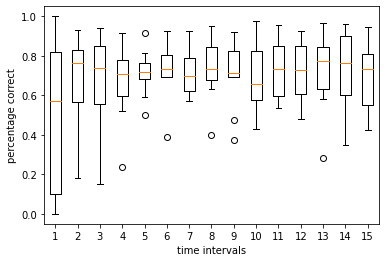

In [12]:
nr_bins = 15

tasks = []

for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskGroup']['name'])
        for s in t['submissions']:
            task.add_submission(s['memberId'], s['status'], s['teamId'], s['uid'], s['timestamp'], s['item']['name'])
        tasks.append(task)
        
bins = []

for t in tasks:
    calculated_bin = t.get_bins(nr_bins)
    bins.append(calculated_bin)
    
average_bin = [0] * len(bins[0])
for b in bins:
    average_bin = [x + y for x, y in zip(average_bin, b)]
average_bin = [x / len(bins) for x in average_bin]

transposed_list = list(map(list, zip(*bins)))
plt.boxplot(transposed_list)
plt.ylabel('percentage correct')
plt.xlabel('time intervals')
plt.savefig('figs/precision_over_time.png')

## Fig. 2 reconstruction:

In [16]:
teams = dict()

for t in data['description']['teams']:
    teams[t['uid']] = Team(t['uid'], t['name'])

for task in data['tasks']:
    for submission in task['submissions']:
        teams[submission['teamId']].add_task(task['position'], submission['status'], task['description']['taskGroup']['name'])
      
df_list = []    
        
for team in teams:
    df_list.append(teams[team].to_df())
    
df = pd.concat(df_list)
df = df.fillna(0)
cols = df.columns.tolist()
cols.insert(11, cols.pop(34))
cols.insert(16, cols.pop(35))
cols.insert(20, cols.pop(36))
cols.insert(2, cols.pop(37))
cols.insert(24, cols.pop(38))
cols.insert(5, cols.pop(39))
cols.insert(16, cols.pop(40))

df = df[cols]

df = df.T

df.to_csv('./csv/nr_incorrect.csv')

df.to_latex('./tex/nr_incorrect.tex')

## Fig. 3 reconstruction:

In [18]:
def get_team_values_df(team, rank_zero, path_to_team='../data/logged_rankings/'):
    tasks = []

    teamId = ''

    teamName = team
    
    if teamName == 'SOMHunter':
        teamName = 'SomHunter'
    elif teamName == 'LegacySOMHunter':
        teamName = 'VBS2020 Winner'
    elif teamName == 'CollageHunter':
        teamName = 'SIRET'
    elif teamName == 'viret':
        teamName = 'VIRET'
    
    for t in data['description']['teams']:
        if t['name'] == teamName:
            teamId = t['uid']
            break
    print(teamId)

    for t in data['tasks']:
        if t['description']['taskType']['name'] == 'Visual KIS' or t['description']['taskType']['name'] == 'Textual KIS':
            task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskType']['name'])
            task.add_name(t['description']['name'])
            cst = -1
            for s in t['submissions']:
                if s['status'] == 'CORRECT' and s['teamId'] == teamId:
                    cst = s['timestamp']
                    break
            task.add_correct_submission_time(cst)
            videoId = t['description']['target']['item']['name']
            timeshot = int(t['description']['target']['temporalRange']['start']['value'] * 1000)
            shotId = -1
            sorted_list = list(map(int, v3c1_ids[videoId].keys()))
            i = 0
            next_key = 0
            for k in sorted_list:
                iter_key = next_key
                next_key = k
                if timeshot >= iter_key and timeshot < next_key:
                    shotId = v3c1_ids[videoId][str(iter_key)]
                    break
            task.add_correct_shot_and_video(shotId, videoId)
            tasks.append(task)

    for root, dirs, files in os.walk(path_to_team + team):
        for file in files:
            path = os.path.join(root, file)
            if file == '.DS_Store':
                continue
            with open(path) as f:
                ranked_list = json.load(f)
                timestamp = int(os.path.splitext(file)[0])
                for task in tasks:
                    if task.timestamp_within(timestamp):
                        adj_logged_time = task.get_logged_time(timestamp)
                        vitrivr = team == 'vitrivr' or team == 'vitrivr-vr'
                        visione = team == 'VISIONE'
                        somHunter = team == 'CollageHunter' or team == 'LegacySOMHunter' or team == 'SOMHunter'
                        viret = team == 'viret'
                        task.add_new_ranking(ranked_list['results'], adj_logged_time, vitrivr, visione, somHunter, viret)
                        break
            

    calc_dict = dict()
    calc_dict['name'] = []
    calc_dict['r_s'] = []
    calc_dict['r_v'] = []
    calc_dict['t'] = []
    calc_dict['t_cs'] = []

    for task in tasks:
        name = task.get_name()
        r_s, r_v, t, t_cs = task.get_rel_info(rank_zero)
        calc_dict['name'].append(name)
        calc_dict['r_s'].append(r_s)
        calc_dict['r_v'].append(r_v)
        calc_dict['t'].append(t)
        calc_dict['t_cs'].append(t_cs)
    df = pd.DataFrame(data=calc_dict, index=calc_dict['name'])
    df = df.drop(columns=['name'])
    df.replace([np.inf, -np.inf], -1, inplace=True)
    df = df.astype('int32')
    df[df < 0] = -1
    df = df.astype('str')
    df.replace(['-1'], '-', inplace=True)
    return df


In [28]:
team = 'vitrivr'
rank_zero = True
df1 = get_team_values_df(team, rank_zero)
df1.to_csv('./csv/vitrivr_calc.csv', '/Volumes/F-A23/')

f3bc2977-0e56-4984-a46e-08ebad673bdb


In [29]:
team = 'vitrivr-vr'
rank_zero = True
df2 = get_team_values_df(team, rank_zero)
df2.to_csv('./csv/vitrivr_vr_calc.csv', '/Volumes/F-A23/')

443d8be7-e381-4fbd-ba46-ff2514db3117


In [30]:
team = 'VideoGraph'
rank_zero = True
df3 = get_team_values_df(team, rank_zero)
df3.to_csv('./csv/videoGraph_calc.csv', '/Volumes/F-A23/')

a265bf53-7e8c-4122-92bc-ee38772d1058


In [31]:
team = 'VERGE'
rank_zero = True
df4 = get_team_values_df(team, rank_zero)
df4.to_csv('./csv/VERGE_calc.csv', '/Volumes/F-A23/')

4449ae20-04f9-44dc-aed2-cec6330c3e83


In [32]:
team = 'VISIONE'
rank_zero = False
df5 = get_team_values_df(team, rank_zero)
df5.to_csv('./csv/VISIONE_calc.csv', '/Volumes/F-A23/')

7bf90d4b-a2e6-49db-b7af-b7dbb91d01e7


In [34]:
team = 'viret'
rank_zero = True
df6 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df6.to_csv('./csv/viret_calc.csv')

f43dc2f2-0e0b-40d8-bfb0-f019bc895b5b


In [35]:
team = 'CollageHunter'
rank_zero = True
df7 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/dres/')
df7.to_csv('./csv/CollageHunter_calc.csv')

b231f852-86ea-4f7f-84bd-b2f87a94e467


In [36]:
team = 'LegacySOMHunter'
rank_zero = True
df8 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/dres/')
df8.to_csv('./csv/LegacySOMHunter_calc.csv')

0a2860d2-b2c9-4fe5-adc2-c02534b25911


In [37]:
team = 'SOMHunter'
rank_zero = True
df9 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/dres/')
df9.to_csv('./csv/SOMHunter_calc.csv')

c69fbcda-041c-458f-b4e7-5e2e3c1f9489


## Create latex from calculations

Warning: First execute the corresponding Dataframe creations!

In [38]:
total_df = pd.concat([df1, df2], axis=1)
total_df = pd.concat([total_df, df3], axis=1)
total_df = pd.concat([total_df, df4], axis=1)
total_df = pd.concat([total_df, df5], axis=1)
total_df = pd.concat([total_df, df6], axis=1)
total_df = pd.concat([total_df, df7], axis=1)
total_df = pd.concat([total_df, df8], axis=1)
total_df = pd.concat([total_df, df9], axis=1)
total_df = total_df.T
total_df.to_csv('./csv/total_calc.csv')
total_df.to_latex('./tex/total_calc.tex')

## AVS submissions over time:

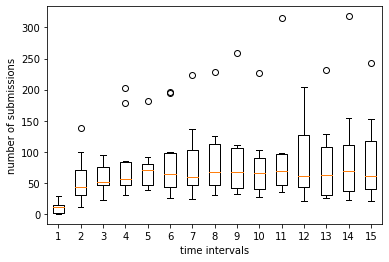

In [39]:
nr_bins = 15

tasks = []

for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskGroup']['name'])
        for s in t['submissions']:
            task.add_submission(s['memberId'], s['status'], s['teamId'], s['uid'], s['timestamp'], s['item']['name'])
        tasks.append(task)
        
bins = []

for t in tasks:
    calculated_bin = t.get_number_of_submissions_in_bins(nr_bins)
    bins.append(calculated_bin)
    
average_bin = [0] * len(bins[0])
for b in bins:
    average_bin = [x + y for x, y in zip(average_bin, b)]

average_bin = [x / len(bins) for x in average_bin]

transposed_list = list(map(list, zip(*bins)))

plt.boxplot(transposed_list)
plt.ylabel('number of submissions')
plt.xlabel('time intervals')
plt.savefig('figs/avs_submissions_over_time.png')

## VBS Submissions over tasks

<Figure size 432x288 with 0 Axes>

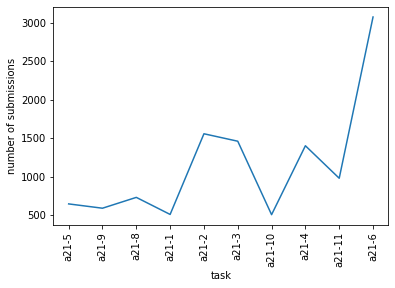

In [40]:
nr_bins = 15

tasks = []

for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskGroup']['name'])
        task.add_name(t['description']['name'])
        for s in t['submissions']:
            task.add_submission(s['memberId'], s['status'], s['teamId'], s['uid'], s['timestamp'], s['item']['name'])
        tasks.append(task)
        
bins = OrderedDict()

for t in tasks:
    calculated_bin = t.get_number_of_submissions_in_bins(nr_bins)
    bins[t.get_name()] = calculated_bin
    
df = pd.DataFrame(data=bins)

df = df.T
df = df.sum(axis = 1, skipna = True)
#df = df.sort_index()
df = df.to_frame()
#idx = df.index.tolist()
#id1 = idx.pop(1)
#idx.append(id1)
#id1 = idx.pop(1)
#idx.append(id1)
#df = df.reindex(idx)

fig = plt.figure()
ax = df.reset_index().plot(x='index', y=0)
plt.ylabel('number of submissions'); plt.xlabel('task')
plt.xticks(df.reset_index().index, df.reset_index()['index'], rotation=90)
#ax.set_yscale('log')
ax.get_legend().remove()
plt.savefig('figs/vbs_submissions_over_tasks.png')


## Precision/Recall and other metrics table:

In [41]:
teams = dict()
recall_total = dict()
video_recall = dict()

for t in data['description']['teams']:
    teams[t['uid']] = Team(t['uid'], t['name'])
    
index = 0
for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        recall_total[t['description']['name']] = dict()
        video_recall[t['description']['name']] = dict()
        for k in teams.keys():
            task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskGroup']['name'])
            task.add_name(t['description']['name'])
            teams[k].add_avs_task(task, index)
        for s in t['submissions']:
            teams[s['teamId']].add_avs_submission(index, s['memberId'], s['status'], s['teamId'], s['uid'], s['timestamp'], s['item']['name'])
            recall_total[t['description']['name']][s['item']['name'] + str(s['temporalRange']['start']['value']) + str(s['temporalRange']['end']['value'])] = 1
            video_recall[t['description']['name']][s['item']['name']] = 1
        index += 1
        
team_dfs = dict()
        
for t in teams:
    teams_dict = dict()
    team = teams[t]
    for i in range(index):
        task = team.get_avs_task(i)
        teams_dict[task.get_name() + 't'] = task.get_correct_submissions()
        teams_dict[task.get_name() + 'f'] = task.get_incorrect_or_indeterminate_submissions()
        teams_dict[task.get_name() + 'prec'] = task.get_precision()
        teams_dict[task.get_name() + 'rec'] = task.get_correct_submissions() / len(recall_total[task.get_name()])
    team_dfs[team.get_name()] = teams_dict
    
df = pd.DataFrame(data=team_dfs)
    
df = df.round(3)
df.to_latex('./tex/prec_rec.tex')


## PR Plot

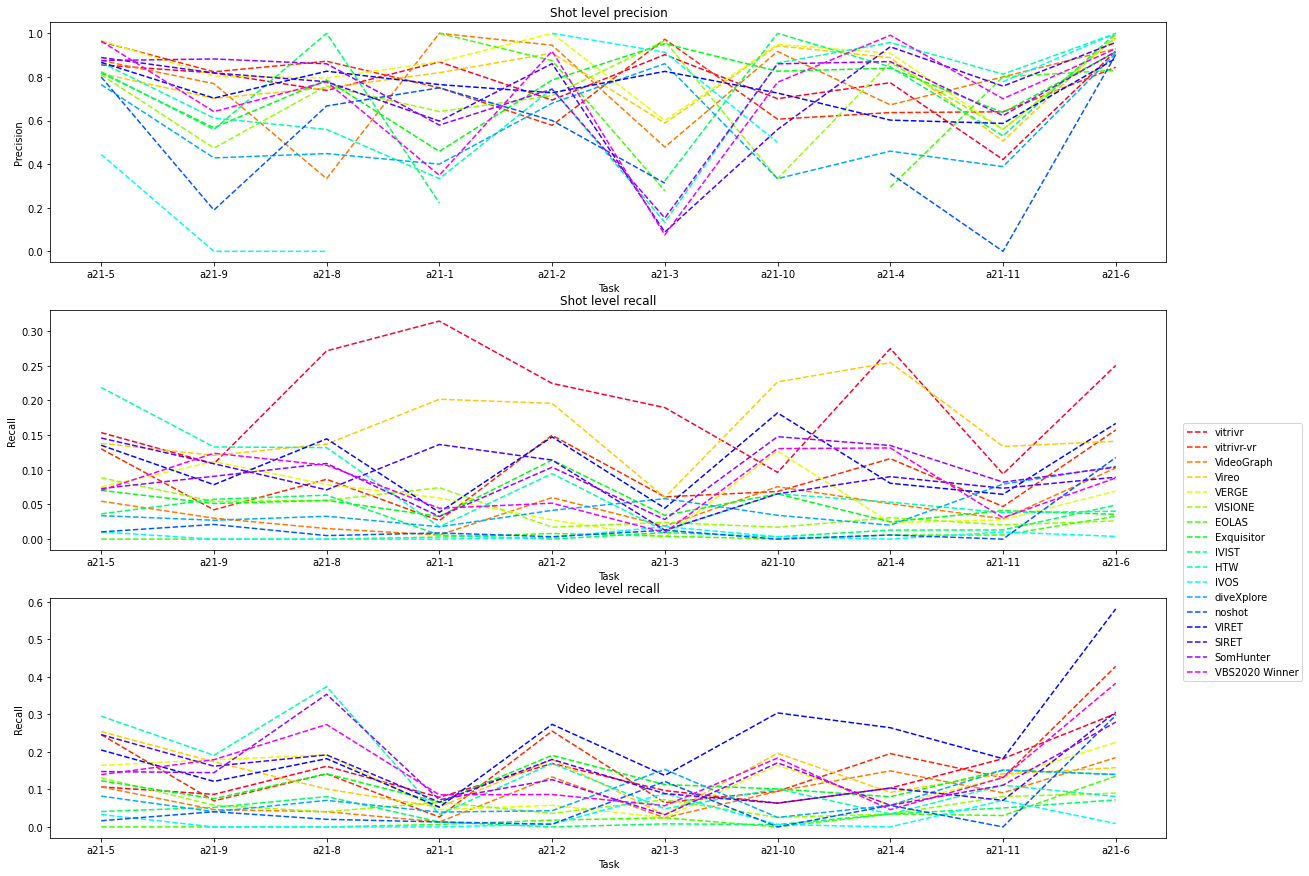

In [42]:
team_names = []
task_names = dict()
precision_total = []
recall_total_2 = []
video_recall_2 = []

for t in teams:
    team = teams[t]
    team_names.append(team.get_name())
    precision = []
    recall = []
    video_recall_inner = []
    for i in range(index):
        task = team.get_avs_task(i)
        task_names[task.get_name()] = 1
        precision.append(task.get_precision())
        recall.append((task.get_correct_submissions() / len(recall_total[task.get_name()])))
        video_recall_inner.append((task.get_correct_video_submissions() / len(video_recall[task.get_name()])))
    precision_total.append(precision)
    recall_total_2.append(recall)
    video_recall_2.append(video_recall_inner)
        
task_names = task_names.keys()

NUM_COLORS = len(team_names)

cm = plt.get_cmap('gist_rainbow')
fig, axs = plt.subplots(3,figsize=(20,15))
axs[0].set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
axs[1].set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
axs[2].set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

axs[0].set_xlabel("Task")
axs[0].set_ylabel("Precision")
axs[0].set_title("Shot level precision")

for i in range(len(precision_total)):
    axs[0].plot(task_names,[pt for pt in precision_total[i]],label = '%s'%team_names[i], linestyle='dashed')

axs[1].set_xlabel("Task")
axs[1].set_ylabel("Recall")
axs[1].set_title("Shot level recall")

for i in range(len(precision_total)):
    axs[1].plot(task_names,[pt for pt in recall_total_2[i]],label = '%s'%team_names[i], linestyle='dashed')

axs[2].set_xlabel("Task")
axs[2].set_ylabel("Recall")
axs[2].set_title("Video level recall")

for i in range(len(precision_total)):
    axs[2].plot(task_names,[pt for pt in video_recall_2[i]],label = '%s'%team_names[i], linestyle='dashed')

    
plt.legend(bbox_to_anchor=(1.01, 1.75), loc='upper left')
    
plt.savefig('figs/precision_recall.png')

## MSB to unified format

In [12]:
header = ['video', 'segment', 'start', 'startframe', 'end', 'endframe']

with open('../data/v3_c1_frame_segments.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for root, dirs, files in os.walk('../data/msb'):
        sorted_files = sorted(files)
        for file in sorted_files:
            tsv_file = open(root + '/' + file)
            read_tsv = csv.reader(tsv_file, delimiter="\t")
            segmentId = 0
            videoId = os.path.splitext(file)[0]
            for row in read_tsv:
                if segmentId != 0:
                    write_row = [videoId, segmentId, int(float(row[1]) * 1000), row[0], int(float(row[3]) * 1000), row[2]]
                    writer.writerow(write_row)
                segmentId += 1
